In [1]:
from fastai.callback.hook import *
from fastbook import *
from fastai.vision.all import *
import fastbook
fastbook.setup_book()
# hide

matplotlib.rc('image', cmap='Greys')


In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)


In [3]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [4]:
dls.c

10

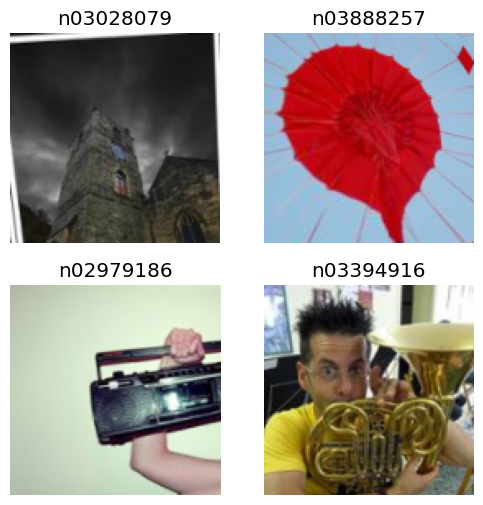

In [5]:
dls.show_batch(max_n=4)

In [6]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [7]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                   ).to_fp16()


learn = get_learner(get_model())


In [8]:
#learn.lr_find()


In [9]:
learn.fit_one_cycle(5, 0.0006918309954926372)


c:\Users\yak\MiniConda3\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
c:\Users\yak\MiniConda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.061389,1.901615,0.335541,03:34
1,1.707961,1.660511,0.436688,02:30
2,1.496667,1.535531,0.515414,03:44
3,1.363189,1.354648,0.564841,03:00
4,1.296767,1.371687,0.570446,02:42


In [10]:
def _conv_block(ni, nf, stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))


In [11]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        self.idconv = noop if ni == nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))


In [13]:
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

learn = get_learner(get_model())


In [ ]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 0.0006918309954926372)